### Testing Notebook

This notebook contains the test plan for the autoliftout automation refactor

In [2]:
%load_ext autoreload 
%autoreload 2
from liftout import utils, patterning, actions
from fibsem import acquire, calibration, movement, validation
from fibsem import utils as fibsem_utils
from liftout.detection import detection
from liftout.detection import utils as det_utils
from liftout.sample import Sample, Lamella, AutoLiftoutStage, AutoLiftoutState, MicroscopeState
from fibsem.structures import Point, BeamType
from liftout.detection.detection import DetectionType

from liftout import autoliftout

from autoscript_sdb_microscope_client.structures import AdornedImage, MoveSettings, StagePosition, ManipulatorPosition, Rectangle

import numpy as np
import os
import matplotlib.pyplot as plt
import glob
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Questions
1. What does link_zy do?
2. What does tilt_compucentric do?
3. How do we define eucentricity?
4. What should we do when the system fails?
5. Link ZY only considers stage tilt, not holder pre-tilt

In [3]:
def take_reference_images_and_plot(microscope, image_settings):
    eb_image, ib_image = acquire.take_reference_images(microscope, image_settings)
    utils.plot_two_images(eb_image, ib_image)
    pprint(f"Stage Position: {microscope.specimen.stage.current_position}")

    return eb_image, ib_image

In [4]:
# common
microscope, settings, image_settings, sample, lamella = utils.full_setup()

pprint(image_settings)
pprint(lamella)
pprint(sample)

2022-08-10 08:47:04,360 — root — INFO — connect_to_microscope:16 — Microscope client connecting to [10.0.0.1]
2022-08-10 08:47:04,368 — root — INFO — connect_to_microscope:19 — Microscope client connected to [10.0.0.1]


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]
ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw=0.00015, autocontrast=True, beam_type=<BeamType.ELECTRON: 1>, save=False, label='2022-08-10.08-47-04AM', gamma=GammaSettings(enabled=True, min_gamma=0.15, max_gamma=1.8, scale_factor=0.01, threshold=46), save_path='c:\\Users\\Admin\\Github\\autoliftout\\liftout\\tools\\auto\\tools/test')

        Lamella 999 (999-test-mule). 
        Lamella Coordinates: StagePosition(), 
        Landing Coordinates: StagePosition(), 
        Current Stage: AutoLiftoutStage.Setup,
        History: 0 stages completed ([]).
        
Sample: 
        Path: c:\Users\Admin\Github\autoliftout\liftout\tools\auto\tools\test
        State: None
        Lamella: 1
        


##### 1. Mill Trench
1. Mill a trench so we have a feature to work with

In [9]:
microscope.patterning.clear_patterns()
milling_settings = patterning.get_milling_protocol_stage_settings(settings, patterning.MillingPattern.Trench)
for stage_settings in milling_settings:
    patterns = patterning.mill_trench_patterns(microscope, stage_settings)

##### 2. Get State
1. Move to trench
2. Get the microscope state

2022-08-10 08:52:37,987 — root — INFO — autocontrast:24 — automatically adjusting contrast...


MicroscopeState(timestamp=1660085557.897017, absolute_position=StagePosition(x=-0.016093667, y=0.052503333, z=0.025196084, t=-3.902525e-07, r=0.85543016, coordinate_system=Raw), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.0040049403613012045, beam_current=2e-10, hfw=0.00015, resolution='1536x1024', dwell_time=1e-06, stigmation=Point(x=0, y=0)), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=0.01641313029959785, beam_current=2e-11, hfw=0.00015, resolution='1536x1024', dwell_time=1e-06, stigmation=Point(x=0, y=0)))


2022-08-10 08:52:38,754 — root — INFO — acquire_image:150 — acquiring new ELECTRON image.
2022-08-10 08:52:42,207 — root — INFO — gamma_correction:50 — GAMMA_CORRECTION | Electron | -21.811 | 1.000
2022-08-10 08:52:42,222 — root — INFO — autocontrast:24 — automatically adjusting contrast...
2022-08-10 08:52:44,463 — root — INFO — acquire_image:150 — acquiring new ION image.
2022-08-10 08:52:46,339 — root — INFO — gamma_correction:50 — GAMMA_CORRECTION | Ion | 6.913 | 1.000


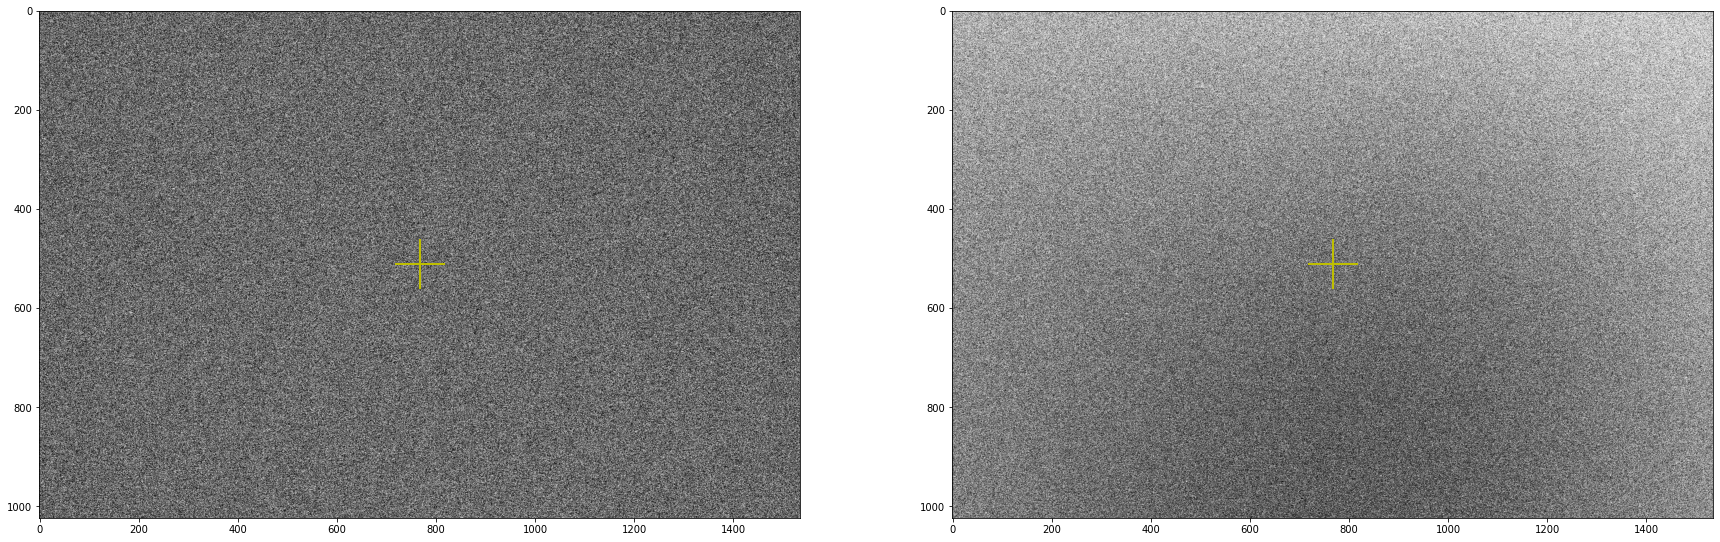

('Stage Position: StagePosition(x=-0.015580708, y=0.051709542, z=0.025196084, '
 't=-3.902525e-07, r=0.87292119, coordinate_system=Specimen)')


(AdornedImage(width=1536, height=1024, bit_depth=8),
 AdornedImage(width=1536, height=1024, bit_depth=8))

In [7]:
# move manually.

microscope_state: MicroscopeState = calibration.get_current_microscope_state(microscope)
pprint(microscope_state)

# show images
take_reference_images_and_plot(microscope, image_settings)

##### 3. Set State

1. Move the stage away from the trench state
2. Restore the microscope state 

In [ ]:
# move away manually
calibration.set_microscope_state(microscope, microscope_state)

# show images
take_reference_images_and_plot(microscope, image_settings)

#### 4. Stage Movement

Test the accuracy of the new stage movement function

Stage movement
1. Move to trench
2. Take reference images
3. Move away from trench
4. Test stage movement with link_zy (eucentricity should be maintained) move back to trench
5. Compare accuracy, and drift in both beams 


In [ ]:
# move to trench manually

# take reference images
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)


In [ ]:
# move away manually

# take reference images
pre_eb, pre_ib = take_reference_images_and_plot(microscope, image_settings)

dx = 10.e-6
dy = 10.e-6

movement.move_stage_relative_with_corrected_movement(
    microscope, settings, dx=dx, dy=dy, beam_type=BeamType.ELECTRON
)

utils.plot_two_images(ref_eb, ref_ib)
post_eb, post_ib = take_reference_images_and_plot(microscope, image_settings)



Tilt Stability
1. Move to trench
2. Take refernece images
3. Tilt the stage with tilt_compucentric option
4. take reference images
5. Compare central position after tilt

In [ ]:
# move to trench manually

# take reference images
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# tilt +6
move_settings = MoveSettings(rotate_compucentric=True, tilt_compucentric=True, link_z_y=True)
microscope.specimen.stage.relative_move(StagePosition(t=np.deg2rad(6)))
tilt_eb, tilt_ib = take_reference_images_and_plot(microscope, image_settings)

# tilt -6
move_settings = MoveSettings(rotate_compucentric=True, tilt_compucentric=True, link_z_y=True)
microscope.specimen.stage.relative_move(StagePosition(t=-np.deg2rad(6)))
flat_eb, flat_ib = take_reference_images_and_plot(microscope, image_settings)

##### 5. Needle Movement

Test the accuracy of the new needle movement function

Insertion stability
1. Insert Needle
2. Change the needle insertion position to be lower in EB.
2. Repeat needle insertion to check stability


In [ ]:
# move stage out manually

# take reference images
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# insert needle
movement.insert_needle(microscope)

# take reference images
print(f"insert to park position")
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# retract
movement.retract_needle(microscope)

for i in range(3):
    print(f"insert to liftout position")
    movement.insert_needle(microscope)
    movement.move_needle_closer(microscope, x_shift=-20e-6, z_shift=-160e-6, y_shift=0.0e-6) 
    ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)
    movement.retract_needle(microscope)


Needle Movement
1. Insert Needle 
2. Move needle to centre of EB image with new needle movement function
3. Compare accuracy

In [ ]:
# move stage out manually

print("before insert")
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

print("after insert")
actions.move_needle_to_liftout_position(microscope)

ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

print("y-movement")
# TODO: calculate the move properly?
dx = 20e-6
dy = 0.0e-6

movement.move_needle_relative_with_corrected_movement(microscope, settings, 
        dx=dx, 
        dy=dy, 
        beam_type=BeamType.ELECTRON)

ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# vertical movement
print("z-movement")
# TODO: calculate the move properly?
dx = 0.0e-6
dy = -5.0e-6
movement.move_needle_relative_with_corrected_movement(microscope, settings, 
        dx=dx, 
        dy=dy, 
        beam_type=BeamType.ION)

ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)



##### 6. CrossCorrelation

Flat Cross Correlation
1. Move to trench (flat IB)
2. Take reference images
3. Move flat to EB
4. Cross correlate (rotated ref_ib)
5. Measure accuracy, how far away is the lamella centre
6. Try masking reference image to improve accuracy


In [ ]:
# manually move to trench

# TODO: do this for low res and high res??
# image_settings.hfw = 400.e-6
# image_settings.hfw = 150.e-6
# image_settings.hfw = 80.e-6

# move flat to ib
movement.flat_to_beam(microscope, settings, beam_type=BeamType.ION)

ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# move flat to eb
movement.flat_to_beam(microscope, settings, beam_type=BeamType.ELECTRON)

new_eb, new_ib = take_reference_images_and_plot(microscope, image_settings)

lp_px = int(max(new_eb.data.shape) * 0.66)
hp_px = int(max(new_eb.data.shape) / 64)
sigma = 6

# cross correlate and plot
utils.crosscorrelate_and_plot(ref_ib, new_eb, rotate=True, lp=lp_px, hp=hp_px, sigma=sigma)

# align and move...
# calibration.align_using_reference_images(microscope, settings, ref_ib, new_eb)


Tilt Cross Correlation
1. Move to trench (flat to EB)
2. Take reference images
3. Tilt +6 degrees
4. Take reference images
5. Cross correlate (eb - eb)
6. Measure accuracy
7. Try masking reference, cosine stretch

In [ ]:
# manually move to trench

# TODO: do this for low res and high res??
# TODO: do this for eb/ib pairs

# image_settings.hfw = 400.e-6
# image_settings.hfw = 150.e-6
# image_settings.hfw = 80.e-6

# move flat to ib
movement.flat_to_beam(microscope, settings, beam_type=BeamType.ELECTRON)
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# titlt to jcut angle
move_settings = MoveSettings(rotate_compucentric=True, tilt_compucentric=True, link_z_y=True)
microscope.specimen.stage.relative_move(StagePosition(t=np.deg2rad(6)))
new_eb, new_ib = take_reference_images_and_plot(microscope, image_settings)

lp_px = int(max(new_eb.data.shape) * 0.66)
hp_px = int(max(new_eb.data.shape) / 64)
sigma = 6

# cross correlate and plot
utils.crosscorrelate_and_plot(ref_ib, new_ib, rotate=False, lp=lp_px, hp=hp_px, sigma=sigma)

# align and move...
# calibration.align_using_reference_images(microscope, settings, ref_ib, new_ib)

##### 7. Eucentric Correction

Cross Correlation eucentric correction
1. Move to trench
2. make eucentricity bad
3. test eucentric correction function (CC)


N.B. Need to test this in other conditions for robustness


In [ ]:
# move stage eucentric

In [ ]:
# manually move to trench

# manually make eucentricy bad

# take reference
print("before correction")
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# test eucentric stage movement
dy = 0.5e-6
movement.move_stage_eucentric_correction(
    microscope, settings, dy=dy, beam_type=BeamType.ION
)

print("after correction")
new_eb, new_ib = take_reference_images_and_plot(microscope, image_settings)


In [ ]:
# test the automated version
calibration.automatic_eucentric_correction_v2(microscope, settings, image_settings,)

Cross Correlation Focus correction
1. Move to trench
2. make eucentricity bad
3. test eucentric correction function (focus)

In [ ]:
# TODO

##### 8. Detection


Liftout Detection
1. Move to Trench
2. Take Reference Images
3. Insert Needle
4. Take reference images
5. Detect initial needle position








In [ ]:
# manually move to trench

# ref images
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# insert needle to liftout position
actions.move_needle_to_liftout_position(microscope)

# new images
new_eb, new_ib = take_reference_images_and_plot(microscope, image_settings)

# detect needle tip  
det = detection.locate_shift_between_features_v2(
        adorned_img=new_eb, 
        ref_image=ref_eb, 
        shift_type=(DetectionType.NeedleTip, DetectionType.ImageCentre), 
        settings=settings)

fig = det_utils.plot_detection_result(det)
plt.show()
plt.close(fig)

# try for multiple positions


Needle Movement Following
1. Do Liftout Detection
2. Plan Needle movement (move to image centre)
3. Predict next needle position
4. Detect needle position using predicted position



In [ ]:
# new needle position should be the final position of previous step?
# TODO
# use the initial reference and see the difference?


Brightness Detection
1. Insert Needle
2. Move vertically above trench
3. Move needle verticall down
4. measure brightness
5. Plot brightness over time
6. Compare images, and brightness values

In [ ]:
# manually move to trench

# ref images
ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# insert needle to liftout position
actions.move_needle_to_liftout_position(microscope)


# manually move needle above trench




# take image
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings) 

# measure brightness
BRIGHTNESS_FACTOR  = 1.2
CROP_SIZE = 250
previous_brightness = calibration.measure_brightness(ib_image, crop_size=CROP_SIZE)

image_settings.hfw = settings["calibration"]["reference_images"][
    "hfw_super_res"
]
image_settings.label = f"needle_liftout_post_z_half_movement_highres"

brightness_history = []

while True:
    last_image = ib_image

    # move needle down 1um
    movement.move_needle_relative_with_corrected_movement(
        microscope, settings, dx=0, dy=-1.e-6, beam_type=BeamType.ION
    )

    # take image
    reduced_area = Rectangle(0.4, 0.4, 0.2, 0.2)     # TODO: use reduced area? faster?
    ib_image = acquire.new_image(microscope, image_settings)
    brightness = calibration.measure_brightness(ib_image, crop_size=CROP_SIZE)

    print(f"previous: {previous_brightness}, current: {brightness}")
    print(f"difference: {brightness-previous_brightness}, {(brightness / previous_brightness)}x ")
    print("---------------------------")

    if brightness > previous_brightness * BRIGHTNESS_FACTOR:
        # needle has landed...

        response = input("Press enter to continue...")
        
        if response != "":
            break
        
    previous_brightness = brightness
    brightness_history.append(brightness)

    # plot data
    fig, ax = plt.subplots(1, 3, figsize=(30, 30))
    ax[0].imshow(last_image.data, cmap="gray")
    ax[1].imshow(ib_image.data, cmap="gray")
    ax[2].plot(brightness_history)
    plt.show()

    response = input("Press enter to continue...")

# take final reference images
image_settings.hfw = settings["calibration"]["reference_images"]["hfw_high_res"]
image_settings.save = True
image_settings.label = f"needle_liftout_landed_lowres"
acquire.take_reference_images(microscope, image_settings)

image_settings.hfw = settings["calibration"]["reference_images"]["hfw_super_res"]
image_settings.label = f"needle_liftout_landed_highres"
acquire.take_reference_images(microscope, image_settings)




''

##### 9. Landing

Landing Detection
1. Move to Landing Post
2. Insert Needle
3. Detect lamella edge
4. Align Y in EB with post
5. Align XZ in IB with post
6. Move needle to make contact with post...

In [ ]:
# manually move to landing post

actions.move_needle_to_landing_position(microscope)

# take image
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings) 

############################################################################################################
# eb alignment
det = detection.locate_shift_between_features_v2(eb_image, None, shift_type=(DetectionType.LamellaEdge, DetectionType.LandingPost), 
    settings=settings)

fig = det_utils.plot_detection_result(det)
plt.show()
plt.close(fig)

print(f"distance: {det.distance_metres}m")

dx = det.distance_metres.x
dy = det.distance_metres.y

movement.move_needle_relative_with_corrected_movement(
    microscope, settings, dx=0, dy=dy, beam_type=BeamType.ELECTRON
)

############################################################################################################
# ib alignment
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings) 

det = detection.locate_shift_between_features_v2(ib_image, None, shift_type=(DetectionType.LamellaEdge, DetectionType.LandingPost), 
    settings=settings)

fig = det_utils.plot_detection_result(det)
plt.show()
plt.close(fig)

print(f"distance: {det.distance_metres}m")

# up is down
dx = det.distance_metres.x
dy = det.distance_metres.y

movement.move_needle_relative_with_corrected_movement(
    microscope, settings, dx=dx, dy=-dy, beam_type=BeamType.ION
)

# TODO:
# repeat while dx > tolerance?
# reduce hfw

##### 10. Reset

Sharpen Needle
1. Move Stage Out
2. Insert Needle
3. Move Needle to Centre
4. Mill Sharpen Needle Pattern

In [25]:
# manually move to landing post

actions.move_sample_stage_out(microscope)

# move needle in
actions.move_needle_to_reset_position(microscope)

# take image
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings) 

############################################################################################################
# ib alignment
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings) 

det = detection.locate_shift_between_features_v2(ib_image, None, shift_type=(DetectionType.NeedleTip, DetectionType.ImageCentre), 
    settings=settings)

fig = det_utils.plot_detection_result(det)
plt.show()
plt.close(fig)

print(f"distance: {det.distance_metres}m")

# up is down
dx = det.distance_metres.x
dy = det.distance_metres.y

movement.move_needle_relative_with_corrected_movement(
    microscope, settings, dx=dx, dy=-dy, beam_type=BeamType.ION
)

# run sharpen needle
patterns = patterning.create_sharpen_needle_patterns(microscope, settings)

Point(x=0.0, y=0.0)


12. Thin Lamella

Align Thin Lamella
1. Move to Landing Position
2. Take reference images
3. Rotate and tilt to thinning angle
4. Take reference images
5. Align to reference images
6. Run Milling

In [ ]:
# manually move to landing position

# take reference images
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings) 

# rotate and tilt to thinning angle
actions.move_to_thinning_angle(microscope, settings)

calibration.correct_stage_drift(microscope, settings, image_settings, alignment=(BeamType.ELECTRON, BeamType.ION), rotate=True)



13. Polish Lamella

Align Polish Lamella
1. Move to thinning position
2. Take reference images
5. Align to reference images
6. Run Milling